# The Cart Pole Environment

> In this tutorial, we will look at the cart pole environment and implement our first agents!

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# set animations to jshtml to render them in browser
# plt.rcParams["animation.html"] = "jshtml"

SEED = 19
rng = np.random.default_rng(SEED)

def new_seed(rng):
    return rng.integers(10_000).item()

In [2]:
def replay(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])
    ax.axis("off")

    def update(frame):
        img.set_data(frame)
        return [img]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())

In [3]:
class Agent:
    """Abstract base class for our cart pole agents."""

    def act(self, obs):
        raise NotImplementedError()

In [4]:
def evaluate_agent(agent: Agent, n_episodes=10, rng=None):
    """Evaluate the agent's average performance over multiple episodes."""
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    rng = np.random.default_rng(rng)

    seed = new_seed(rng)
    observation, info = env.reset(seed=seed)

    total_reward = 0
    for i in range(n_episodes):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.act(observation)
            # apply the selected action to the environment
            observation, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
        seed = new_seed(rng)
        env.reset(seed=seed)
    env.close()

    return total_reward / n_episodes

In [5]:
def play_episode(agent, seed=19):
    """Run one episode and return replay."""
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    observation, info = env.reset(seed=seed)

    frames = []

    terminated = False
    truncated = False

    while not (terminated or truncated):
        frames.append(env.render())
        action = agent.act(observation)
        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)
    env.close()
    
    return replay(frames)

## 1. A Random Agent

Let's start by implementing an agent that just randomly selects an action:

In [6]:
class RandomAgent(Agent):
    """Select a random action."""
    def __init__(self, rng=None):
        self.rng = np.random.default_rng(rng)

    def act(self, obs):
        # TODO: randomly select an action
        raise NotImplementedError()

In [7]:
# Solution

class RandomAgent(Agent):
    """Select a random action."""
    def __init__(self, rng=None):
        self.rng = np.random.default_rng(rng)

    def act(self, obs):
        return self.rng.choice([0,1])

In [8]:
random_agent = RandomAgent(rng=SEED)

evaluate_agent(random_agent, rng=SEED)

21.6

In [9]:
play_episode(random_agent)

Authorization required, but no authorization protocol specified



## 2. A Naive Approach: Using the Pole Angle

In [10]:
class AngularAgent(Agent):
    """Go either left or right depending on the pole angle."""

    def act(self, obs):
        # 2 is the pole angle
        if obs[2] > 0:
            return 1
        else:
            return 0

In [11]:
angular_agent = AngularAgent()

evaluate_agent(angular_agent, rng=19)

45.9

In [12]:
play_episode(angular_agent)

Authorization required, but no authorization protocol specified



## 3. Data-Driven Approach

In [13]:
rewards = []

for i in range(1000):
    r = evaluate_agent(random_agent, n_episodes=1)
    rewards.append(r)

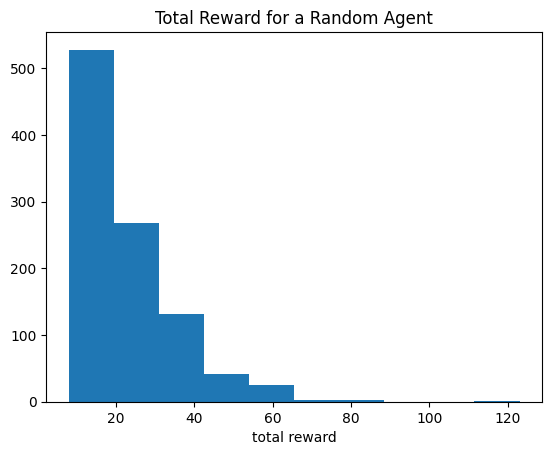

In [14]:
plt.hist(rewards)
plt.title("Total Reward for a Random Agent")
plt.xlabel("total reward");

We can see that even with random actions, sometimes the agent survives up to 100 frames!
That means that until then, the random agent did not too bad.

Can we use the frames were the agent randomly made the right decisions to somehow train an agent that actually works well?

In [15]:
def generate_train_data(n=100, reward_threshold=50):
    """
    Perform random actions to generate data for n episodes that exceed the reward threshold.
    """
    train_data = []
    data = []

    env = gym.make("CartPole-v1", render_mode="rgb_array")

    observation, info = env.reset(seed=19)
    total_reward = 0

    while len(train_data) < n:
        # select a random action
        action = env.action_space.sample()

        data.append({
            "observation": observation,
            "action": action
        })

        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            env.reset()
            data = []
            total_reward = 0
        
        total_reward += reward

        if total_reward >= reward_threshold:
            # save observations and actions as train data
            env.reset()
            train_data.append(data)
            data = []
            total_reward = 0

    return train_data


In [16]:
train_data = generate_train_data()

In [17]:
x = np.concat([
    np.stack([x["observation"] for x in data]) for data in train_data
])

y = np.concat([
    np.array([x["action"] for x in data]) for data in train_data
])

In [18]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5)

model.fit(x, y)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


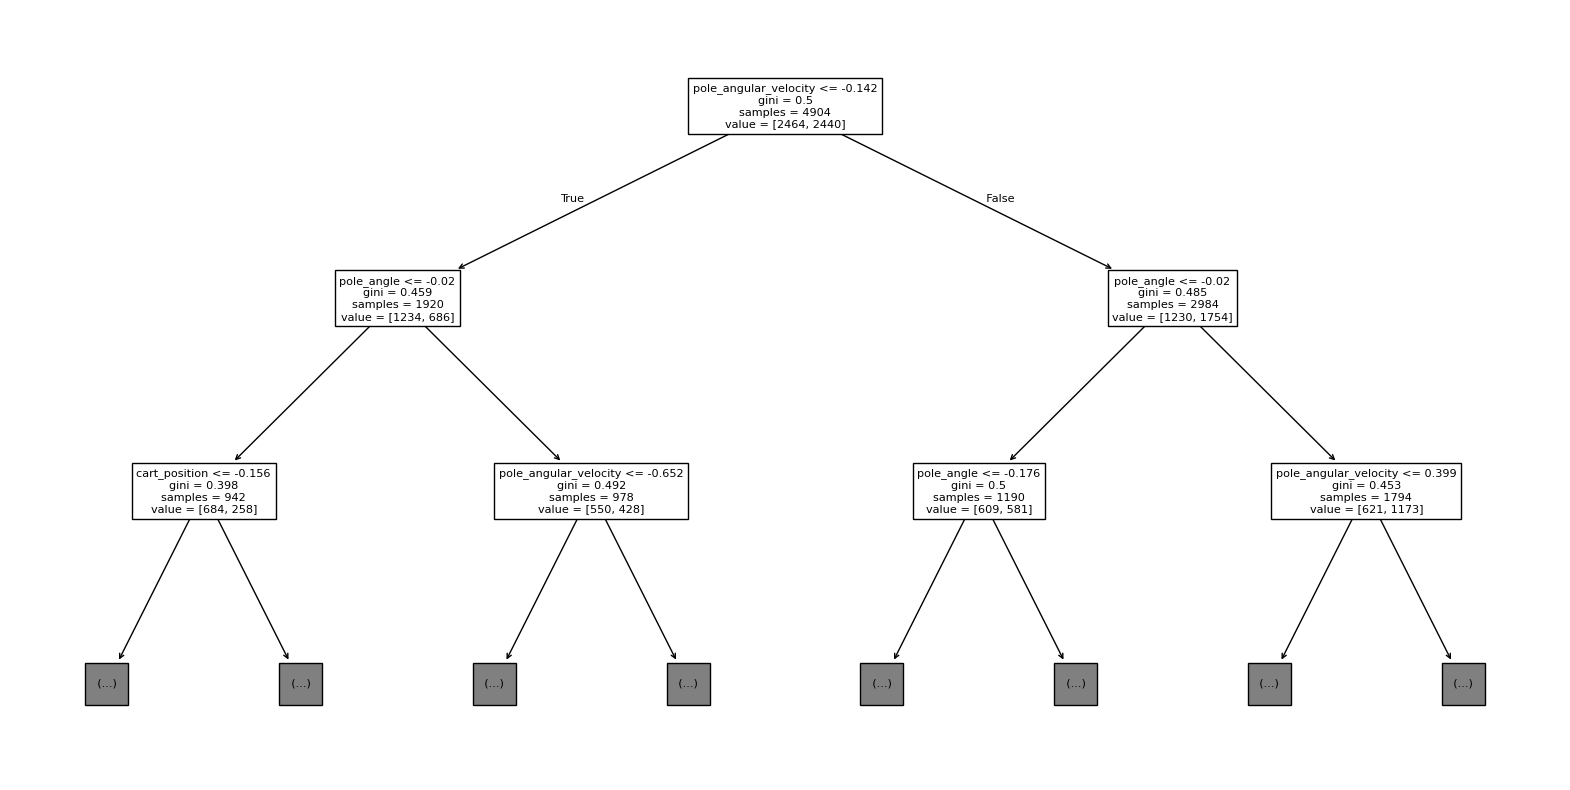

In [19]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20,10))
feature_names = ["cart_position", "cart_velocity", "pole_angle", "pole_angular_velocity"]

plot_tree(model, max_depth=2, feature_names=feature_names, ax=ax);

In [20]:
class ModelAgent(Agent):
    def __init__(self, model):
        self.model = model
    
    def act(self, observation):
        action = self.model.predict(observation.reshape(1,4)).item()
        return action

In [21]:
model_agent = ModelAgent(model)

evaluate_agent(model_agent)

338.3

In [ ]:
play_episode(model_agent)

Authorization required, but no authorization protocol specified



However, until now, we just tried out simple strategies, that are not actually using Reinforcement Learning.